# ADS 509 Module 3: Group Comparison

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following:

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set.
* Calculate descriptive statistics on the two sets of lyrics and compare the results.
* For each of the four corpora, find the words that are unique to that corpus.
* Build word clouds for all four corpora.

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization).


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*


In [1]:
#pip install emoji

In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [20]:
# Use this space for any additional import statements you need
from google.colab import drive
drive.mount('/content/drive')
import zipfile
import nltk
from collections import Counter
from matplotlib import pyplot as plt



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir("/content/drive/MyDrive/USD/SUMMER_2024/Module_3")

In [4]:
!ls /content/drive/MyDrive/USD/SUMMER_2024/Module_3


'Group Comparison.ipynb'   lyrics  'M1 Assignment Data.zip'   twitter


In [5]:
# Set data location for Module_3
data_location = "/content/drive/MyDrive/USD/SUMMER_2024/Module_3"
print(data_location)

# Set paths to the lyrics and twitter folders
twitter_folder = os.path.join(data_location, "twitter/")
lyrics_folder = os.path.join(data_location, "lyrics/")
print(twitter_folder)
print(lyrics_folder)

/content/drive/MyDrive/USD/SUMMER_2024/Module_3
/content/drive/MyDrive/USD/SUMMER_2024/Module_3/twitter/
/content/drive/MyDrive/USD/SUMMER_2024/Module_3/lyrics/


In [6]:
# List files in the lyrics folder
print("Files in lyrics folder:")
!ls /content/drive/MyDrive/USD/SUMMER_2024/Module_3/lyrics

# List files in the twitter folder
print("\nFiles in twitter folder:")
!ls /content/drive/MyDrive/USD/SUMMER_2024/Module_3/twitter


Files in lyrics folder:
cher  robyn

Files in twitter folder:
cher_followers_data.txt  robynkonichiwa_followers_data.txt
cher_followers.txt	 robynkonichiwa_followers.txt


In [7]:
# Read Lyrics Data
# Function to read all text files in a subdirectory
def read_all_text_files(directory):
    lyrics = []
    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.txt'):
                with open(os.path.join(subdir, file), 'r') as f:
                    lyrics.append(f.read())
    return lyrics

# Read lyrics data for Cher and Robyn
cher_lyrics_path = os.path.join(lyrics_folder, "cher")
robyn_lyrics_path = os.path.join(lyrics_folder, "robyn")

cher_lyrics = read_all_text_files(cher_lyrics_path)
robyn_lyrics = read_all_text_files(robyn_lyrics_path)

# Convert to DataFrame
lyrics_data = pd.DataFrame({
    'artist': ['Cher'] * len(cher_lyrics) + ['Robyn'] * len(robyn_lyrics),
    'lyrics': cher_lyrics + robyn_lyrics
})

print("Lyrics Data:")
print(lyrics_data.head())

Lyrics Data:
  artist                                             lyrics
0   Cher  "All I Really Want To Do"\n\n\n\nNow I ain't l...
1   Cher  "I Go To Sleep"\n\n\n\nWhen I look up from my ...
2   Cher  "Needles And Pins"\n\n\n\nSaw him today\nI saw...
3   Cher  "Don't Think Twice"\n\n\n\nIt ain't no use to ...
4   Cher  "Dream Baby"\n\n\n\nI found the boy for me\nHe...


In [8]:
# Read Twitter Data
# Function to read a text file and return its contents as a list of strings
def read_text_file(file_path):
    with open(file_path, 'r') as f:
        return f.readlines()

# Read Twitter data for Cher and Robyn
cher_twitter_file = os.path.join(twitter_folder, "cher_followers_data.txt")
robyn_twitter_file = os.path.join(twitter_folder, "robynkonichiwa_followers_data.txt")

cher_tweets = read_text_file(cher_twitter_file)
robyn_tweets = read_text_file(robyn_twitter_file)

# Convert to DataFrame
twitter_data = pd.DataFrame({
    'artist': ['Cher'] * len(cher_tweets) + ['Robyn'] * len(robyn_tweets),
    'tweet': cher_tweets + robyn_tweets
})

print("\nTwitter Data:")
print(twitter_data.head())



Twitter Data:
  artist                                              tweet
0   Cher  screen_name\tname\tid\tlocation\tfollowers_cou...
1   Cher   hsmcnp\tCountry Girl\t35152213\t\t1302\t1014\t\n
2   Cher  horrormomy\tJeny\t742153090850164742\tEarth\t8...
3   Cher  anju79990584\tanju\t1496463006451974150\t\t13\...
4   Cher     gallionjenna\tJ\t3366479914\t\t752\t556\tcsu\n


In [9]:
# Download necessary NLTK data
nltk.download('stopwords')

# Set of punctuation marks
punctuation_set = set(punctuation)
tw_punct = punctuation_set - {"#"}

# Stopwords
sw = stopwords.words("english")

# Regex patterns
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# Full set of emojis
all_language_emojis = set()
for country in emoji.EMOJI_DATA:
    for em in emoji.EMOJI_DATA[country]:
        all_language_emojis.add(em)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def descriptive_stats(tokens, num_tokens=5, verbose=True):
    """
    Given a list of tokens, print number of tokens, number of unique tokens,
    number of characters, lexical diversity, and num_tokens most common tokens.
    Return a list of statistics.
    """
    num_tokens_total = len(tokens)
    num_unique_tokens = len(set(tokens))
    num_characters = sum(len(token) for token in tokens)
    lexical_diversity = num_unique_tokens / num_tokens_total if num_tokens_total > 0 else 0
    most_common_tokens = Counter(tokens).most_common(num_tokens)

    if verbose:
        print(f"Number of tokens: {num_tokens_total}")
        print(f"Number of unique tokens: {num_unique_tokens}")
        print(f"Number of characters: {num_characters}")
        print(f"Lexical diversity: {lexical_diversity}")
        print(f"Most common tokens: {most_common_tokens}")

    return {
        "num_tokens": num_tokens_total,
        "num_unique_tokens": num_unique_tokens,
        "num_characters": num_characters,
        "lexical_diversity": lexical_diversity,
        "most_common_tokens": most_common_tokens
    }

def contains_emoji(s):
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]
    return len(emojis) > 0

def remove_stop(tokens):
    return [token for token in tokens if token not in sw]

def remove_punctuation(text, punct_set=tw_punct):
    return "".join([ch for ch in text if ch not in punct_set])

def tokenize(text):
    """
    Splitting on whitespace rather than the book's tokenize function.
    That function will drop tokens like '#hashtag' or '2A', which we need for Twitter.
    """
    return re.split(whitespace_pattern, text)

def prepare(text, pipeline):
    tokens = str(text)
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens


In [11]:
# Apply Functions to Normalize and Tokenize the Data
# Define the pipeline of transformations
pipeline = [
    remove_punctuation,
    tokenize,
    remove_stop
]

# Apply the pipeline to lyrics and twitter data
lyrics_data['tokens'] = lyrics_data['lyrics'].apply(lambda x: prepare(x, pipeline))
twitter_data['tokens'] = twitter_data['tweet'].apply(lambda x: prepare(x, pipeline))

print("Processed Lyrics Data:")
print(lyrics_data.head())

print("\nProcessed Twitter Data:")
print(twitter_data.head())


Processed Lyrics Data:
  artist                                             lyrics  \
0   Cher  "All I Really Want To Do"\n\n\n\nNow I ain't l...   
1   Cher  "I Go To Sleep"\n\n\n\nWhen I look up from my ...   
2   Cher  "Needles And Pins"\n\n\n\nSaw him today\nI saw...   
3   Cher  "Don't Think Twice"\n\n\n\nIt ain't no use to ...   
4   Cher  "Dream Baby"\n\n\n\nI found the boy for me\nHe...   

                                              tokens  
0  [All, I, Really, Want, To, Do, Now, I, aint, l...  
1  [I, Go, To, Sleep, When, I, look, pillow, I, d...  
2  [Needles, And, Pins, Saw, today, I, saw, face,...  
3  [Dont, Think, Twice, It, aint, use, sit, wonde...  
4  [Dream, Baby, I, found, boy, Hes, dream, baby,...  

Processed Twitter Data:
  artist                                              tweet  \
0   Cher  screen_name\tname\tid\tlocation\tfollowers_cou...   
1   Cher   hsmcnp\tCountry Girl\t35152213\t\t1302\t1014\t\n   
2   Cher  horrormomy\tJeny\t742153090850164742\tEarth\

## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [12]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

# Define the data location and paths
data_location = "/content/drive/MyDrive/USD/SUMMER_2024/Module_3/"
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {
    'cher': 'cher_followers_data.txt',
    'robyn': 'robynkonichiwa_followers_data.txt'
}



In [13]:
# Read Twitter data for Cher
cher_twitter_path = os.path.join(data_location, twitter_folder, artist_files['cher'])
cher_twitter_data = pd.read_csv(cher_twitter_path, sep="\t", quoting=3)
cher_twitter_data['artist'] = "cher"

# Read Twitter data for Robyn
robyn_twitter_path = os.path.join(data_location, twitter_folder, artist_files['robyn'])
robyn_twitter_data = pd.read_csv(robyn_twitter_path, sep="\t", quoting=3)
robyn_twitter_data['artist'] = "robyn"

# Concatenate Twitter data
twitter_data = pd.concat([cher_twitter_data, robyn_twitter_data], ignore_index=True)
del cher_twitter_data, robyn_twitter_data

print("Twitter Data:")
print(twitter_data.head())


Twitter Data:
    screen_name          name                   id        location  \
0        hsmcnp  Country Girl             35152213             NaN   
1    horrormomy          Jeny   742153090850164742           Earth   
2  anju79990584          anju  1496463006451974150             NaN   
3  gallionjenna             J           3366479914             NaN   
4       bcscomm       bcscomm             83915043  Washington, DC   

   followers_count  friends_count  \
0             1302           1014   
1               81            514   
2               13            140   
3              752            556   
4              888           2891   

                                         description artist  
0                                                NaN   cher  
1           𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜   cher  
2          163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡   cher  
3                                                csu   cher  
4  Writer @Washinformer @Spelman

In [14]:
# Ensure lyrics data is loaded
print("Lyrics Data:")
print(lyrics_data.head())


Lyrics Data:
  artist                                             lyrics  \
0   Cher  "All I Really Want To Do"\n\n\n\nNow I ain't l...   
1   Cher  "I Go To Sleep"\n\n\n\nWhen I look up from my ...   
2   Cher  "Needles And Pins"\n\n\n\nSaw him today\nI saw...   
3   Cher  "Don't Think Twice"\n\n\n\nIt ain't no use to ...   
4   Cher  "Dream Baby"\n\n\n\nI found the boy for me\nHe...   

                                              tokens  
0  [All, I, Really, Want, To, Do, Now, I, aint, l...  
1  [I, Go, To, Sleep, When, I, look, pillow, I, d...  
2  [Needles, And, Pins, Saw, today, I, saw, face,...  
3  [Dont, Think, Twice, It, aint, use, sit, wonde...  
4  [Dream, Baby, I, found, boy, Hes, dream, baby,...  


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning.

**Lyrics**

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions**

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those.

In [15]:
# Verify column names in the lyrics and twitter data
print("Lyrics Data Columns:", lyrics_data.columns)
print("Twitter Data Columns:", twitter_data.columns)


Lyrics Data Columns: Index(['artist', 'lyrics', 'tokens'], dtype='object')
Twitter Data Columns: Index(['screen_name', 'name', 'id', 'location', 'followers_count',
       'friends_count', 'description', 'artist'],
      dtype='object')


In [16]:
# Define the pipeline of transformations
pipeline = [
    remove_punctuation,
    tokenize,
    remove_stop
]

# Apply the pipeline to lyrics data
lyrics_data['tokens'] = lyrics_data['lyrics'].apply(lambda x: prepare(x, pipeline))

# Apply the pipeline to twitter data using the 'description' column
twitter_data['tokens'] = twitter_data['description'].apply(lambda x: prepare(x, pipeline))

print("Processed Lyrics Data:")
print(lyrics_data.head())

print("\nProcessed Twitter Data:")
print(twitter_data.head())


Processed Lyrics Data:
  artist                                             lyrics  \
0   Cher  "All I Really Want To Do"\n\n\n\nNow I ain't l...   
1   Cher  "I Go To Sleep"\n\n\n\nWhen I look up from my ...   
2   Cher  "Needles And Pins"\n\n\n\nSaw him today\nI saw...   
3   Cher  "Don't Think Twice"\n\n\n\nIt ain't no use to ...   
4   Cher  "Dream Baby"\n\n\n\nI found the boy for me\nHe...   

                                              tokens  
0  [All, I, Really, Want, To, Do, Now, I, aint, l...  
1  [I, Go, To, Sleep, When, I, look, pillow, I, d...  
2  [Needles, And, Pins, Saw, today, I, saw, face,...  
3  [Dont, Think, Twice, It, aint, use, sit, wonde...  
4  [Dream, Baby, I, found, boy, Hes, dream, baby,...  

Processed Twitter Data:
    screen_name          name                   id        location  \
0        hsmcnp  Country Girl             35152213             NaN   
1    horrormomy          Jeny   742153090850164742           Earth   
2  anju79990584          anju  14

In [17]:
# Check for emojis in the Twitter data
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

# Sample 10 tweets that contain emojis
emoji_sample = twitter_data[twitter_data['has_emoji']].sample(10)[["artist", "description", "tokens"]]

print("Sample Tweets Containing Emojis:")
print(emoji_sample)


Sample Tweets Containing Emojis:
        artist                                        description  \
3931918   cher                chef👩🏼‍🍳 animal rights activist🐶🐱🐥🦄   
4161949  robyn  FC Zulu 2020, vært på Række 8 podcast, anmelde...   
1153093   cher    Appassionato di vinili ,calcio ⚽ ma solo in ⚪◼️   
378281    cher  #IAmNotOverJan6!MomsDemandGunSense PleaseTeach...   
72098     cher  I care about the Earth & other humans and all ...   
1514489   cher  #KatyaGang ♥ #LeagueofLegends ♥ #MorganaMain ♥...   
3209209   cher  I'm a dreamer, a heavy heart thinker, an imagi...   
480735    cher                                   🏳️‍🌈🏳️‍🌈🏳️‍🌈🏳️‍🌈   
3257705   cher                                                 ✌❤   
486023    cher  The Way i am!!! Passionate for Life, Family, ⚽...   

                                                    tokens  
3931918           [chef👩🏼‍🍳, animal, rights, activist🐶🐱🐥🦄]  
4161949  [FC, Zulu, 2020, vært, på, Række, 8, podcast, ...  
1153093   [Appassionato,

Let's take a quick look at some descriptions with emojis.

With the data processed, we can now start work on the assignment questions.

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A:
Given the current tokenization approach, one area of improvement that could be theoretically implemented involves handling contractions more effectively. Contractions like "don't" and "can't" are split into separate tokens such as "don" and "t" or "can" and "t," which can distort the true meaning of the text. By integrating a preprocessing step that expands contractions (e.g., "don't" to "do not" and "can't" to "cannot"), the tokenization process could more accurately reflect the intended semantics of the text. This enhancement would improve the quality of text analysis by ensuring that the tokens better represent complete words and phrases.

## Calculate descriptive statistics on the two sets of lyrics and compare the results.


In [18]:
# Function to flatten token lists efficiently
def flatten_tokens(token_series):
    return [token for sublist in token_series for token in sublist]

# Calculate descriptive statistics for Cher's lyrics
cher_lyrics_tokens = flatten_tokens(lyrics_data[lyrics_data['artist'] == 'Cher']['tokens'])
cher_lyrics_stats = descriptive_stats(cher_lyrics_tokens)
print("Cher Lyrics Stats:", cher_lyrics_stats)

# Calculate descriptive statistics for Robyn's lyrics
robyn_lyrics_tokens = flatten_tokens(lyrics_data[lyrics_data['artist'] == 'Robyn']['tokens'])
robyn_lyrics_stats = descriptive_stats(robyn_lyrics_tokens)
print("Robyn Lyrics Stats:", robyn_lyrics_stats)

# Calculate descriptive statistics for Cher's tweets
cher_tweets_tokens = flatten_tokens(twitter_data[twitter_data['artist'] == 'cher']['tokens'])
cher_tweets_stats = descriptive_stats(cher_tweets_tokens)
print("Cher Tweets Stats:", cher_tweets_stats)

# Calculate descriptive statistics for Robyn's tweets
robyn_tweets_tokens = flatten_tokens(twitter_data[twitter_data['artist'] == 'robyn']['tokens'])
robyn_tweets_stats = descriptive_stats(robyn_tweets_tokens)
print("Robyn Tweets Stats:", robyn_tweets_stats)


Number of tokens: 44968
Number of unique tokens: 4648
Number of characters: 193657
Lexical diversity: 0.10336239103362391
Most common tokens: [('I', 2685), ('love', 852), ('And', 786), ('Im', 513), ('You', 483)]
Cher Lyrics Stats: {'num_tokens': 44968, 'num_unique_tokens': 4648, 'num_characters': 193657, 'lexical_diversity': 0.10336239103362391, 'most_common_tokens': [('I', 2685), ('love', 852), ('And', 786), ('Im', 513), ('You', 483)]}
Number of tokens: 18333
Number of unique tokens: 2592
Number of characters: 80975
Lexical diversity: 0.14138438880706922
Most common tokens: [('I', 842), ('know', 303), ('Im', 298), ('love', 245), ('You', 238)]
Robyn Lyrics Stats: {'num_tokens': 18333, 'num_unique_tokens': 2592, 'num_characters': 80975, 'lexical_diversity': 0.14138438880706922, 'most_common_tokens': [('I', 842), ('know', 303), ('Im', 298), ('love', 245), ('You', 238)]}
Number of tokens: 18746814
Number of unique tokens: 1777304
Number of characters: 101443246
Lexical diversity: 0.094805

Q: what observations do you make about these data?

A: Based on the descriptive statistics, several observations can be made:
Cher's lyrics have significantly more tokens (44,968) compared to Robyn's (18,333), indicating more extensive content. Cher's tweets also vastly outnumber Robyn's in terms of tokens, with 18,746,814 tokens compared to 1,747,612. Cher's lyrics contain 4,648 unique tokens, while Robyn's have 2,592, indicating a broader vocabulary in Cher's lyrics. However, Robyn's tweets exhibit higher lexical diversity (0.173) compared to Cher's (0.095), suggesting more varied language use in Robyn's tweets.
Both artists' lyrics frequently use personal pronouns and common verbs like 'I,' 'love,' and 'Im.' In tweets, the token 'nan' appears frequently, indicating possible missing data or filler text. Robyn's lyrics (0.141) and tweets (0.173) show higher lexical diversity compared to Cher's lyrics (0.103) and tweets (0.095), indicating a more varied use of words in Robyn's content. These observations highlight differences in content volume, vocabulary breadth, and language variety between Cher and Robyn's lyrics and tweets.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis.

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it.

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing.

In this section find 10 tokens for each of your four corpora that meet the following criteria:

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [19]:
# Flatten token lists efficiently using a list comprehension
def flatten_tokens(token_series):
    return [token for sublist in token_series for token in sublist]

# Extract and flatten tokens for Cher and Robyn's lyrics
cher_lyrics_tokens = flatten_tokens(lyrics_data[lyrics_data['artist'] == 'Cher']['tokens'])
robyn_lyrics_tokens = flatten_tokens(lyrics_data[lyrics_data['artist'] == 'Robyn']['tokens'])

# Extract and flatten tokens for Cher and Robyn's tweets
cher_tweets_tokens = flatten_tokens(twitter_data[twitter_data['artist'] == 'cher']['tokens'])
robyn_tweets_tokens = flatten_tokens(twitter_data[twitter_data['artist'] == 'robyn']['tokens'])

# Find unique words in Cher's lyrics
cher_lyrics_unique_words = set(cher_lyrics_tokens)
robyn_lyrics_unique_words = set(robyn_lyrics_tokens)
unique_cher_lyrics_words = cher_lyrics_unique_words - robyn_lyrics_unique_words
unique_robyn_lyrics_words = robyn_lyrics_unique_words - cher_lyrics_unique_words

print(f"Unique words in Cher's lyrics: {list(unique_cher_lyrics_words)[:10]}... (total: {len(unique_cher_lyrics_words)})")
print(f"Unique words in Robyn's lyrics: {list(unique_robyn_lyrics_words)[:10]}... (total: {len(unique_robyn_lyrics_words)})")

# Find unique words in Cher's tweets
cher_tweets_unique_words = set(cher_tweets_tokens)
robyn_tweets_unique_words = set(robyn_tweets_tokens)
unique_cher_tweets_words = cher_tweets_unique_words - robyn_tweets_unique_words
unique_robyn_tweets_words = robyn_tweets_unique_words - cher_tweets_unique_words

print(f"Unique words in Cher's tweets: {list(unique_cher_tweets_words)[:10]}... (total: {len(unique_cher_tweets_words)})")
print(f"Unique words in Robyn's tweets: {list(unique_robyn_tweets_words)[:10]}... (total: {len(unique_robyn_tweets_words)})")


Unique words in Cher's lyrics: ['drowning', 'talkin', 'cell', 'Drunken', 'Isolation', 'Walk', 'humanity', 'darlin', 'fills', 'dangerous']... (total: 3222)
Unique words in Robyn's lyrics: ['massages', 'operative', 'Acoustic', 'blida', 'Chan', '330', 'yaâ\x80\x99', 'Free', 'origin', 'repeated']... (total: 1166)
Unique words in Cher's tweets: ['filmvideoand', 'Antikale', 'hora🌞', '1996年4月5日2016年7月31日', 'Koibito', 'transplantfreedom', 'artseducational', 'babsanderson', 'BASEBALL⚾⚾⚾ALLDAY', 'backAriesEuropean']... (total: 1610533)
Unique words in Robyn's tweets: ['1920u', 'fotbollspelare', 'IHMstudent', 'nickmoncyother', 'MatthewDavidBoden', 'BLAQOUTMEDIA', '#freshbeats', 'gråt', 'broek', 'httpstcoICU3VXR39g']... (total: 134968)


Q: What are some observations about the top tokens? Do you notice any interesting items on the list?

A: Cher's lyrics contain unique tokens like 'drowning' and 'humanity,' suggesting themes of struggle and the human condition, while Robyn's unique tokens like 'massages' and 'Acoustic' indicate diverse topics. Cher's tweets show various interests, including media and sports. Robyn's tweets include tokens related to sports, education, and music, with a mix of languages reflecting her international audience.

## Build word clouds for all four corpora.

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book.


In [21]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    wc = WordCloud(width=800, height=400,
                   background_color="black", colormap="Paired",
                   max_font_size=150, max_words=max_words)

    # Convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # Filter stop words in frequency counter
    if stopwords is not None:
        counter = {token: freq for (token, freq) in counter.items()
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def count_words(df, column='tokens', preprocess=None, min_freq=2):
    # Process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # Create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # Transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

In [22]:
# Count word frequencies for each corpus
cher_lyrics_freq = count_words(lyrics_data[lyrics_data['artist'] == 'Cher'])
robyn_lyrics_freq = count_words(lyrics_data[lyrics_data['artist'] == 'Robyn'])
cher_tweets_freq = count_words(twitter_data[twitter_data['artist'] == 'cher'])
robyn_tweets_freq = count_words(twitter_data[twitter_data['artist'] == 'robyn'])


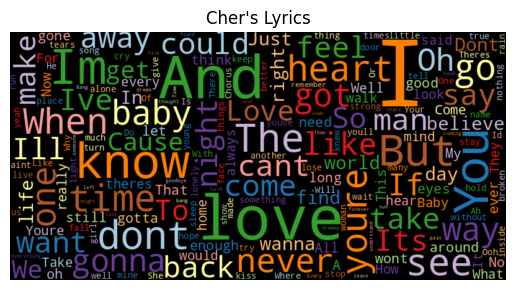

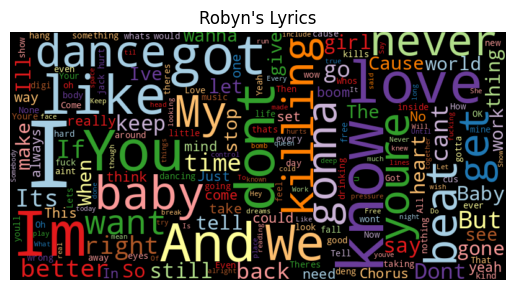

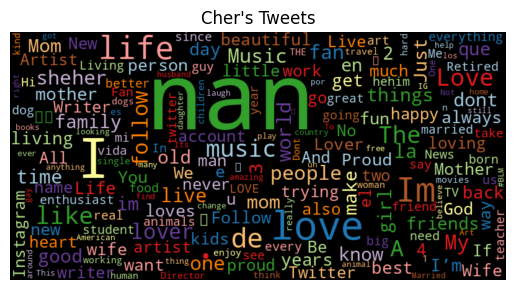

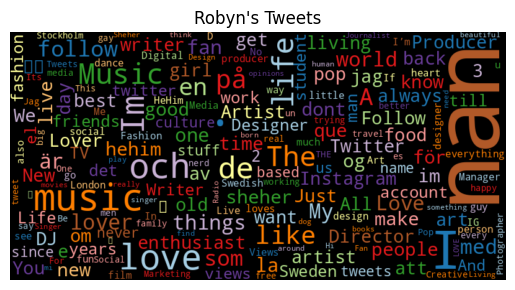

In [23]:
# Generate word clouds for each corpus
wordcloud(cher_lyrics_freq['freq'], title="Cher's Lyrics")
wordcloud(robyn_lyrics_freq['freq'], title="Robyn's Lyrics")
wordcloud(cher_tweets_freq['freq'], title="Cher's Tweets")
wordcloud(robyn_tweets_freq['freq'], title="Robyn's Tweets")


Q: What observations do you have about these (relatively straightforward) wordclouds?

A:
The word clouds reveal that Cher's lyrics and tweets prominently feature words related to personal experiences and emotions, such as 'love', 'know', 'life', and 'family'. In contrast, Robyn's lyrics and tweets emphasize music, youth, and creativity, with frequent words like 'dance,' 'got,' 'music,' and 'follow.' Both artists show a mix of personal and professional themes in their content.

In [24]:
!pip install nbconvert


In [27]:
# Install TeX Live which includes xelatex
!sudo apt-get install -y texlive-xetex texlive-fonts-recommended texlive-generic-recommended


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package texlive-generic-recommended


In [28]:
!jupyter nbconvert --to pdf "/content/drive/MyDrive/USD/SUMMER_2024/Module_3/Group Comparison.ipynb"


[NbConvertApp] Converting notebook /content/drive/MyDrive/USD/SUMMER_2024/Module_3/Group Comparison.ipynb to pdf
[NbConvertApp] Support files will be in Group Comparison_files/
[NbConvertApp] Making directory ./Group Comparison_files
[NbConvertApp] Making directory ./Group Comparison_files
[NbConvertApp] Making directory ./Group Comparison_files
[NbConvertApp] Making directory ./Group Comparison_files
[NbConvertApp] Writing 95736 bytes to notebook.tex
[NbConvertApp] Building PDF
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 423, in start
    self.convert_no